In [1]:
import matplotlib.pyplot as plt

In [112]:

import pandas as pd

dfBen = pd.read_excel("../shared_data_read_only/Data/Article1/Hackaton_Benevoles_JPMORGAN.xlsx")
dfBin = pd.read_excel("../shared_data_read_only/Data/Article1/Hackaton_Binomes_JPMORGAN.xlsx")
dfJeu = pd.read_excel("../shared_data_read_only/Data/Article1/Hackaton_Jeunes_JPMORGAN.xlsx")

df = pd.read_csv("../shared_documents/pairs_cleaned.csv")

/tmp/ipykernel_65189/3511626153.py:7: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../shared_documents/pairs_cleaned.csv")


In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest

In [120]:
print(dfBen.columns)

Index(['mentor_id', 'registration_date', 'workfield', 'current_role',
       'needs_to_address'],
      dtype='object')


In [121]:
print(dfJeu.columns)

Index(['mentee_id', 'field_of_study', 'study_level', 'degree', 'needs',
       'average_grade', 'program', 'engagement_score', 'registration_date',
       'desired_exchange_frequency', 'hobby', 'project_confidence_level',
       'project_development_level', 'Unnamed: 13', 'Unnamed: 14'],
      dtype='object')


In [114]:
df_work = df.copy()

# 1) registration_date -> days_since_registration
import pandas as pd, numpy as np
df_work["registration_date"] = pd.to_datetime(df_work["registration_date"], errors="coerce")
ref_date = pd.Timestamp.today().normalize()
df_work["days_since_registration"] = (ref_date - df_work["registration_date"]).dt.days


KeyError: 'registration_date'

In [94]:
num_cols = ["average_grade","engagement_score","days_since_registration"]
cat_cols = ["workfield","field_of_study","study_level","degree","needs",
            "program","desired_exchange_frequency","binome_statut"]
id_cols  = [c for c in ["binome_id","mentor_id","mentee_id"] if c in df_work.columns]


In [95]:
cols = [
    'binome_statut', 'binome_acceptance_delay', 'binome_date_update_statut',
    'workfield', 'current_role', 'needs_to_address_mentor',
    'field_of_study', 'study_level', 'degree', 'needs_to_address_mentee',
    'average_grade', 'program', 'engagement_score',
    'registration_date_mentee', 'desired_exchange_frequency', 'hobby',
    'project_confidence_level', 'project_development_level',
    'binome_score_clean'
]
X = df[cols].copy()

X = X.fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.select_dtypes(include=['float64', 'int64']))

# Suppose we want to keep top 5 PCs
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print(f"Cumulative variance: {pca.explained_variance_ratio_.sum()*100:.2f}%")

# Combine into a DataFrame
pca_cols = [f"PC{i}" for i in range(1, 4)]
df_pca_5 = pd.DataFrame(X_pca, columns=pca_cols)

# Optionally attach to your main dataframe
df_out = pd.concat([df.reset_index(drop=True), df_pca_5], axis=1)


Explained variance ratio: [0.31311433 0.22041807 0.19460775]
Cumulative variance: 72.81%


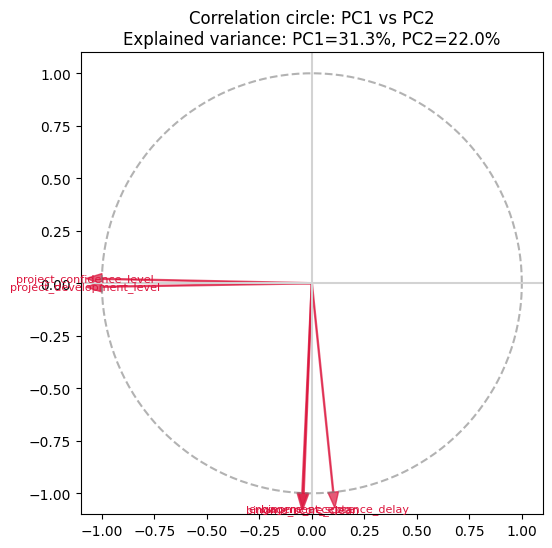

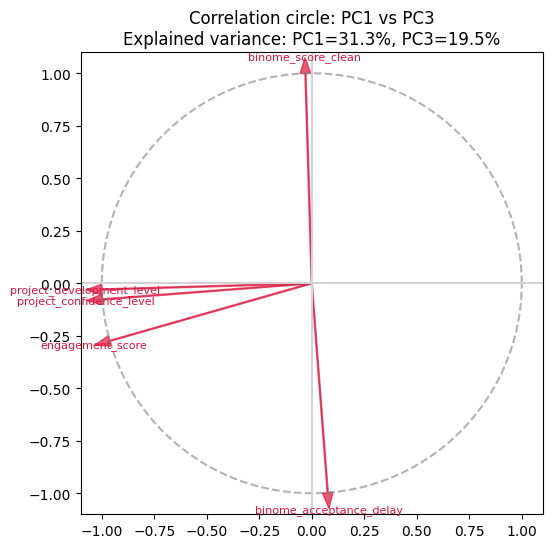

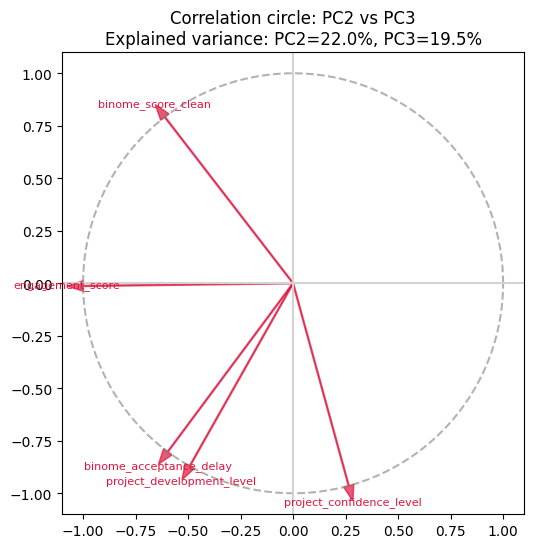

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# 载荷矩阵 (n_features x n_components)
L = pca.components_.T
feature_names = X.select_dtypes(include=['float64','int64']).columns

# 想画的主成分配对
pairs_to_plot = [(1,2), (1,3), (2,3)]  # 自己改成想要的组合

for (pcx, pcy) in pairs_to_plot:
    i, j = pcx-1, pcy-1  # Python index from 0
    
    plt.figure(figsize=(6,6))
    theta = np.linspace(0, 2*np.pi, 300)
    plt.plot(np.cos(theta), np.sin(theta), '--', color='gray', alpha=0.6)  # unit circle
    
    # 每个变量归一化显示方向
    for k in range(L.shape[0]):
        x, y = L[k, i], L[k, j]
        norm = np.sqrt(x**2 + y**2)
        if norm > 1e-6:
            x, y = x / norm, y / norm
        plt.arrow(0, 0, x, y, color='crimson', alpha=0.7, width=0.005, head_width=0.05)
        plt.text(x*1.08, y*1.08, feature_names[k], color='crimson',
                 ha='center', va='center', fontsize=8)
    
    plt.axhline(0, color='lightgray'); plt.axvline(0, color='lightgray')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1)
    plt.title(f"Correlation circle: PC{pcx} vs PC{pcy}\n"
              f"Explained variance: PC{pcx}={pca.explained_variance_ratio_[i]*100:.1f}%, "
              f"PC{pcy}={pca.explained_variance_ratio_[j]*100:.1f}%")
    plt.show()


In [100]:
from sklearn.decomposition import PCA
import pandas as pd

# Fit PCA with 5 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print(f"Cumulative variance: {pca.explained_variance_ratio_.sum()*100:.2f}%")

# Combine PCA results into a DataFrame
pca_cols = [f"PC{i}" for i in range(1, 4)]
df_pca_5 = pd.DataFrame(X_pca, columns=pca_cols)

# Optionally attach to your main dataframe
df_out = pd.concat([df.reset_index(drop=True), df_pca_5], axis=1)

# Save outputs
df_out.to_csv("pca_5components_output.csv", index=False)

print("✅ PCA results saved to 'pca_5components_output.csv'")
print(df_pca_5.head())


Explained variance ratio: [0.31311433 0.22041807 0.19460775]
Cumulative variance: 72.81%
✅ PCA results saved to 'pca_5components_output.csv'
        PC1       PC2       PC3
0  2.558457 -0.796682  0.930699
1  2.517369 -0.702199  1.643421
2  2.517369 -0.702199  1.643421
3  2.526024 -0.480401  1.355916
4  2.515519 -0.990348  1.841719


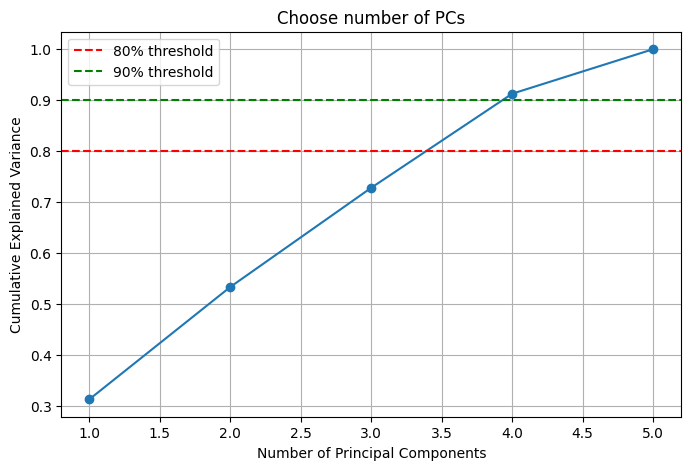

PC1: cumulative variance = 31.31%
PC2: cumulative variance = 53.35%
PC3: cumulative variance = 72.81%
PC4: cumulative variance = 91.27%
PC5: cumulative variance = 100.00%


In [42]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Fit PCA with all possible components
pca_full = PCA().fit(X_scaled)

# Explained variance ratios
evr = np.cumsum(pca_full.explained_variance_ratio_)

# Plot the cumulative explained variance curve
plt.figure(figsize=(8,5))
plt.plot(range(1, len(evr)+1), evr, marker='o')
plt.axhline(0.80, color='r', linestyle='--', label='80% threshold')
plt.axhline(0.90, color='g', linestyle='--', label='90% threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Choose number of PCs')
plt.legend()
plt.grid(True)
plt.show()

# Print the cumulative variance table
for k, v in enumerate(evr, 1):
    print(f"PC{k}: cumulative variance = {v*100:.2f}%")


In [101]:
import pandas as pd

feature_names = X.select_dtypes(include=['float64','int64']).columns

loadings = pd.DataFrame(
    pca.components_.T,
    index=feature_names,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)

TOP = 5
for pc in loadings.columns:
    print(f"\nTop {TOP} features driving {pc}:")
    print(loadings[pc].abs().sort_values(ascending=False).head(TOP))



Top 5 features driving PC1:
project_development_level    0.706016
project_confidence_level     0.705186
binome_acceptance_delay      0.054154
engagement_score             0.029589
binome_score_clean           0.021125
Name: PC1, dtype: float64

Top 5 features driving PC2:
engagement_score             0.653962
binome_score_clean           0.541370
binome_acceptance_delay      0.528101
project_confidence_level     0.014916
project_development_level    0.011799
Name: PC2, dtype: float64

Top 5 features driving PC3:
binome_acceptance_delay      0.709995
binome_score_clean           0.701749
project_confidence_level     0.054298
project_development_level    0.020868
engagement_score             0.008442
Name: PC3, dtype: float64


In [115]:
# y_true = 1 if the pair was successful (COMPLETED or ACTIVE)
# y_true = 0 if it was not (CANCELLED, REJECTED, etc.)
df['y_true'] = df['binome_statut'].isin(['COMPLETED', 'ACTIVE']).astype(int)


In [102]:


pca_df = pd.DataFrame(X_pca, columns=[f"PC{i}" for i in range(1, 4)])
corr = pca_df.corr()
print(np.round(corr, 4))


     PC1  PC2  PC3
PC1  1.0  0.0  0.0
PC2  0.0  1.0 -0.0
PC3  0.0 -0.0  1.0


In [103]:
# ========= Continue from your PCA code =========
# df_out now contains your original columns + PC1, PC2, PC3

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

# 1) Define the supervised label (y_true)
#    Success definition: COMPLETED or ACTIVE -> 1, else 0
df_out['y_true'] = df_out['binome_statut'].isin(['COMPLETED', 'ACTIVE']).astype(int)

# 2) Build feature matrix from PCs
X = df_out[['PC1', 'PC2', 'PC3']].copy()
y = df_out['y_true'].astype(int)

# 3) Train/test split (stratified to keep class balance)
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------- Option A: Logistic Regression (baseline, interpretable) ----------
clf = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
clf.fit(X_tr, y_tr)

y_pred_lr = clf.predict(X_te)
y_proba_lr = clf.predict_proba(X_te)[:, 1]

print("\n[Logistic Regression]")
print("Accuracy:", accuracy_score(y_te, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_te, y_proba_lr))
print(classification_report(y_te, y_pred_lr))
print("Confusion matrix:\n", confusion_matrix(y_te, y_pred_lr))

# Save LR predictions
pred_lr = X_te.copy()
pred_lr['y_true'] = y_te.values
pred_lr['y_pred'] = y_pred_lr
pred_lr['pred_prob'] = y_proba_lr
pred_lr.to_csv("predictions_lr_pc123.csv", index=False)
print("Saved: predictions_lr_pc123.csv")

# Optional: inspect coefficients (which PC drives probability)
coef_lr = pd.Series(clf.coef_[0], index=X.columns).sort_values(ascending=False)
print("\nLR coefficients:\n", coef_lr)

# ---------- Option B: Random Forest (nonlinear, often stronger) ----------
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_tr, y_tr)

y_pred_rf = rf.predict(X_te)
y_proba_rf = rf.predict_proba(X_te)[:, 1]

print("\n[Random Forest]")
print("Accuracy:", accuracy_score(y_te, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_te, y_proba_rf))
print(classification_report(y_te, y_pred_rf))
print("Confusion matrix:\n", confusion_matrix(y_te, y_pred_rf))

# Save RF predictions
pred_rf = X_te.copy()
pred_rf['y_true'] = y_te.values
pred_rf['y_pred'] = y_pred_rf
pred_rf['pred_prob'] = y_proba_rf
pred_rf.to_csv("predictions_rf_pc123.csv", index=False)
print("Saved: predictions_rf_pc123.csv")





[Logistic Regression]
Accuracy: 0.6800610974033604
ROC AUC: 0.6813126405802488
              precision    recall  f1-score   support

           0       0.81      0.73      0.77      6245
           1       0.42      0.54      0.47      2266

    accuracy                           0.68      8511
   macro avg       0.62      0.63      0.62      8511
weighted avg       0.71      0.68      0.69      8511

Confusion matrix:
 [[4571 1674]
 [1049 1217]]
Saved: predictions_lr_pc123.csv

LR coefficients:
 PC1    0.105847
PC3   -0.289628
PC2   -0.485247
dtype: float64

[Random Forest]
Accuracy: 0.7458583010222065
ROC AUC: 0.7710371651248625
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      6245
           1       0.53      0.43      0.47      2266

    accuracy                           0.75      8511
   macro avg       0.67      0.65      0.65      8511
weighted avg       0.73      0.75      0.74      8511

Confusion matrix:
 [[5371  874]


In [75]:
# Bayesian+MCMC
import pymc as pm
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Prepare data
X = df_out[['PC1','PC2','PC3']].to_numpy()
y = df_out['y_true'].astype(int).to_numpy()
n, p = X.shape

# Bayesian logistic regression with MCMC (NUTS)
with pm.Model() as logit_model:
    # Priors
    alpha = pm.Normal("alpha", mu=0, sigma=2)
    beta = pm.Normal("beta", mu=0, sigma=2, shape=p)

    # Linear predictor
    mu = alpha + pm.math.dot(X, beta)
    p_hat = pm.Deterministic("p_hat", pm.math.sigmoid(mu))

    # Likelihood
    y_obs = pm.Bernoulli("y_obs", p=p_hat, observed=y)

    # Sampling
    idata = pm.sample(draws=1000, tune=1000, chains=4, target_accept=0.9, random_seed=42)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 110 seconds.
There were 1000 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [77]:
# Posterior mean of predicted probabilities
p_mean = idata.posterior['p_hat'].stack(sample=("chain","draw")).mean("sample").values

# Classify at threshold 0.5
y_pred = (p_mean >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y, y_pred))
print("ROC AUC:", roc_auc_score(y, p_mean))
print("Confusion matrix:\n", confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))


Accuracy: 0.734149551158528
ROC AUC: 0.5893122120852564
Confusion matrix:
 [[30874   350]
 [10963   367]]
              precision    recall  f1-score   support

           0       0.74      0.99      0.85     31224
           1       0.51      0.03      0.06     11330

    accuracy                           0.73     42554
   macro avg       0.62      0.51      0.45     42554
weighted avg       0.68      0.73      0.64     42554



In [116]:
print(df.columns)

Index(['binome_id', 'binome_statut', 'binome_date_proposition',
       'binome_date_creation', 'binome_acceptance_delay',
       'binome_date_update_statut', 'binome_cancellation_reason',
       'binome_score', 'mentee_id', 'mentor_id', 'registration_date_mentor',
       'workfield', 'current_role', 'needs_to_address_mentor',
       'field_of_study', 'study_level', 'degree', 'needs_to_address_mentee',
       'average_grade', 'program', 'engagement_score',
       'registration_date_mentee', 'desired_exchange_frequency', 'hobby',
       'project_confidence_level', 'project_development_level',
       'binome_score_clean', 'y_true'],
      dtype='object')


In [117]:
# All comments in English
# Purpose: Train RF to capture nonlinearities; then calibrate RF probabilities with Bayesian logistic (MCMC)

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, brier_score_loss, classification_report
from sklearn.preprocessing import StandardScaler
import pymc as pm
import arviz as az

# ---------- 1) Prepare features ----------
df = df.copy()

# Target 0/1
y = df['y_true'].astype(int).values

# Choose numeric and categorical columns (adjust to your data)
num_cols = ['binome_acceptance_delay','engagement_score',
            'project_confidence_level','project_development_level']
cat_cols = ['study_level','field_of_study']

# Ensure numeric
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# One-hot encode categoricals
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Build X
X_cols = num_cols + [c for c in df.columns if any(c.startswith(cat) for cat in cat_cols)]
X = df[X_cols].copy().fillna(0)

# Standardize numeric only
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

X = X.values
# ---------- 2) Random Forest ----------
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

rf = RandomForestClassifier(
    n_estimators=500,
    min_samples_leaf=20,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_tr, y_tr)

rf_prob_tr = rf.predict_proba(X_tr)[:,1]
rf_prob_te = rf.predict_proba(X_te)[:,1]

print("RF AUC (raw):", roc_auc_score(y_te, rf_prob_te))
print("RF Brier (raw):", brier_score_loss(y_te, rf_prob_te))

# ---------- 3) Bayesian calibration (Platt scaling) ----------
def safe_logit(p, eps=1e-6):
    p = np.clip(p, eps, 1-eps)
    return np.log(p/(1-p))

z_tr = safe_logit(rf_prob_tr)
z_te = safe_logit(rf_prob_te)

with pm.Model() as calib:
    # Weakly-informative priors
    a = pm.Normal("a", mu=0.0, sigma=2.5)   # intercept
    b = pm.Normal("b", mu=0.0, sigma=2.5)   # slope on RF logit

    eta = a + b * z_tr
    p = pm.Deterministic("p", pm.math.sigmoid(eta))
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_tr)

    idata_cal = pm.sample(2000, tune=2000, chains=4, target_accept=0.9, random_seed=42)

# Posterior mean parameters
a_post = idata_cal.posterior['a'].stack(d=("chain","draw")).mean("d").item()
b_post = idata_cal.posterior['b'].stack(d=("chain","draw")).mean("d").item()

# Calibrated probabilities on test set
p_cal_te = 1/(1 + np.exp(-(a_post + b_post * z_te)))

print("Calibrated AUC:", roc_auc_score(y_te, p_cal_te))
print("Calibrated Brier:", brier_score_loss(y_te, p_cal_te))
print(classification_report(y_te, (p_cal_te>=0.5).astype(int), digits=2))


Initializing NUTS using jitter+adapt_diag...


RF AUC (raw): 0.8307974396699286
RF Brier (raw): 0.16395486271408652


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 54 seconds.


Calibrated AUC: 0.8307974396699286
Calibrated Brier: 0.13809343798632692
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      9368
           1       0.56      0.64      0.60      3399

    accuracy                           0.77     12767
   macro avg       0.71      0.73      0.72     12767
weighted avg       0.78      0.77      0.77     12767



array([<Axes: title={'center': 'a'}>, <Axes: title={'center': 'b'}>],
      dtype=object)

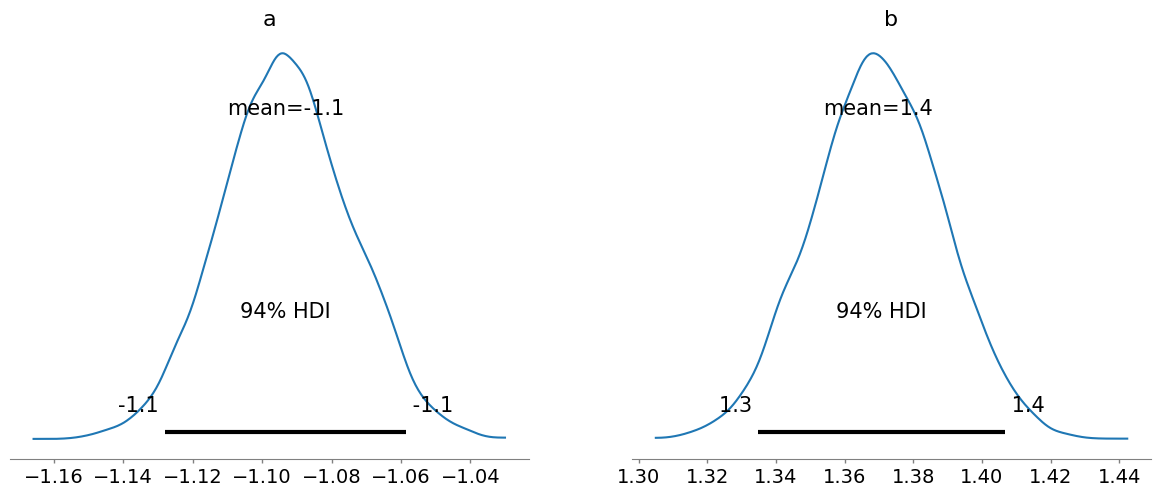

In [118]:
az.plot_posterior(idata_cal, var_names=['a','b'])


In [119]:
p_post_full = idata_cal.posterior['p'].stack(draws=("chain","draw")).values
p_mean = p_post_full.mean(axis=-1)
p_low, p_high = np.percentile(p_post_full, [5,95], axis=-1)
